<a href="https://colab.research.google.com/github/jly123819/jly123819/blob/main/Data_Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1: Data Ingestion

In [9]:
!pip install pandas requests

# 1.1 Ingest Data from Yahoo Finance API

In [10]:
import json
import pandas as pd
import requests

# Ask user for stock symbols
stock = input("Enter stock symbols (comma-separated, e.g., AAPL,GOOGL,MSFT): ")

# API key
apikey = "20vlAA62RCadBlyH3wvWj7hJHxFbqqT642G6FHZP"

# Define URL
url = "https://yfapi.net/v6/finance/quote"

# Define query parameters
querystring = {"symbols": stock}

# Define headers
headers = {'x-api-key': apikey}

# Send request
response = requests.get(url, headers=headers, params=querystring)

# Parse JSON response
data = json.loads(response.text)

# Extract required information
if "quoteResponse" in data and "result" in data["quoteResponse"]:
    results = data["quoteResponse"]["result"]
    yahoo_data = []
    for stock_info in results:
        yahoo_data.append({
            "symbol": stock_info.get("symbol", "N/A"),
            "company": stock_info.get("longName", "N/A"),
            "current_price": stock_info.get("regularMarketPrice", "N/A"),
            "market_cap": stock_info.get("marketCap", "N/A"),
            "volume": stock_info.get("regularMarketVolume", "N/A")
        })
    df_yahoo = pd.DataFrame(yahoo_data)
else:
    print("No data found for the given stock symbols.")

Enter stock symbols (comma-separated, e.g., AAPL,GOOGL,MSFT): AAPL


# 1.2 Ingest NYSE Stock Data from Kaggle

In [11]:
import pandas as pd

# Define the path to the CSV file
file_path = 'fundamentals.csv'

# Try to load the dataset, handle potential errors
try:
    df_nyse = pd.read_csv(file_path)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: The file was not found.")
    raise
except Exception as e:
    print(f"An error occurred: {e}")
    raise

# Display the first few rows and column names for inspection
print("First few rows of the dataset:")
print(df_nyse.head())
print("\nColumn names in the dataset:")
print(df_nyse.columns)

# Select and rename relevant columns
columns_to_keep = ['Ticker Symbol', 'Period Ending', 'Total Revenue', 'Net Income', 'Total Assets']
df_nyse = df_nyse[columns_to_keep]
df_nyse.rename(columns={
    'Ticker Symbol': 'symbol',
    'Period Ending': 'date',
    'Total Revenue': 'total_revenue',
    'Net Income': 'net_income',
    'Total Assets': 'total_assets'
}, inplace=True)

# Convert 'date' column to datetime format and validate conversion
try:
    df_nyse['date'] = pd.to_datetime(df_nyse['date'])
    print("Date conversion successful.")
except pd.errors.OutOfBoundsDatetime:
    print("Date conversion failed: Out of bounds datetime.")
except ValueError:
    print("Date conversion failed: Incorrect date format.")

# Filter data for the last 5 years (adjust according to the actual data range)
start_date = '2013-01-01'  # Adjust this date based on your specific needs
df_nyse = df_nyse[df_nyse['date'] >= pd.Timestamp(start_date)]

# Check if the DataFrame is empty after filtering
if df_nyse.empty:
    print("No data available after filtering.")
else:
    print("Transformed NYSE data:")
    print(df_nyse.head())

# Optionally, save the filtered DataFrame to a new CSV for further analysis
output_path = 'transformed_fundamentals.csv'
df_nyse.to_csv(output_path, index=False)
print(f"Transformed data saved to {output_path}")

Dataset loaded successfully.
First few rows of the dataset:
   Unnamed: 0 Ticker Symbol Period Ending  Accounts Payable  \
0           0           AAL    2012-12-31      3.068000e+09   
1           1           AAL    2013-12-31      4.975000e+09   
2           2           AAL    2014-12-31      4.668000e+09   
3           3           AAL    2015-12-31      5.102000e+09   
4           4           AAP    2012-12-29      2.409453e+09   

   Accounts Receivable  Add'l income/expense items  After Tax ROE  \
0         -222000000.0               -1.961000e+09           23.0   
1          -93000000.0               -2.723000e+09           67.0   
2         -160000000.0               -1.500000e+08          143.0   
3          352000000.0               -7.080000e+08          135.0   
4          -89482000.0                6.000000e+05           32.0   

   Capital Expenditures  Capital Surplus  Cash Ratio  ...  \
0         -1.888000e+09     4.695000e+09        53.0  ...   
1         -3.114000e+09 

# Part 2: Data Transformation

# 2.1 Transform Yahoo Finance Data

In [12]:
# Ensure 'market_cap' is numeric and handle missing or non-numeric values
df_yahoo['market_cap'] = pd.to_numeric(df_yahoo['market_cap'], errors='coerce')

# Convert market cap to a more readable format (e.g., billions) and handle missing values
df_yahoo['market_cap'] = df_yahoo['market_cap'].apply(lambda x: f"{x / 1e9:.2f}B" if pd.notna(x) else "N/A")

# Display the transformed data
print("\nTransformed Yahoo Finance data:")
print(df_yahoo.head())


Transformed Yahoo Finance data:
  symbol     company  current_price market_cap    volume
0   AAPL  Apple Inc.         239.07   3591.33B  45520263


# 2.2 Transform NYSE Stock Data

In [13]:
import numpy as np

# Ensure the DataFrame is not empty before proceeding
if df_nyse.empty:
    print("The DataFrame is empty. Check earlier data ingestion and transformation steps.")
else:
    # Group NYSE data by symbol and calculate summary statistics
    df_nyse_summary = df_nyse.groupby('symbol').agg({
        'total_revenue': ['mean', 'median', 'std'],
        'net_income': ['mean', 'median', 'std'],
        'total_assets': ['mean', 'median', 'std']
    }).reset_index()

    # Handle potential NaN values in statistical results
    df_nyse_summary = df_nyse_summary.fillna(0)

    # Flatten the multi-level column index
    df_nyse_summary.columns = ['_'.join(col).strip() for col in df_nyse_summary.columns.values]

    # Display the summary data
    if df_nyse_summary.empty:
        print("No summary data available after grouping and aggregation.")
    else:
        print("\nSummary of NYSE data:")
        print(df_nyse_summary.head())


Summary of NYSE data:
  symbol_  total_revenue_mean  total_revenue_median  total_revenue_std  \
0     AAL        3.679433e+10          4.099000e+10       8.744191e+09   
1     AAP        8.691564e+09          9.737018e+09       1.904057e+09   
2    AAPL        2.007648e+11          1.992170e+11       2.898954e+10   
3    ABBV        2.053633e+10          1.996000e+10       2.094829e+09   
4     ABC        1.225849e+11          1.277655e+11       2.566293e+10   

   net_income_mean  net_income_median  net_income_std  total_assets_mean  \
0     2.886000e+09       2.882000e+09    4.722001e+09       4.463933e+10   
1     4.529937e+08       4.733980e+08    5.400621e+07       7.220566e+09   
2     4.390700e+10       4.259850e+10    7.296165e+09       2.627175e+11   
3     3.682000e+09       4.128000e+09    1.728702e+09       3.658700e+10   
4     4.994252e+08       3.539685e+08    6.642470e+08       2.551750e+10   

   total_assets_median  total_assets_std  
0         4.322500e+10      3.30

# 2.3 Data Merging

In [14]:
df_yahoo.columns = df_yahoo.columns.str.strip()
df_nyse_summary.columns = df_nyse_summary.columns.str.strip()

In [15]:
print("Exact column names in df_yahoo:")
for col in df_yahoo.columns:
    print(f"'{col}'", type(col))

print("Exact column names in df_nyse_summary:")
for col in df_nyse_summary.columns:
    print(f"'{col}'", type(col))

Exact column names in df_yahoo:
'symbol' <class 'str'>
'company' <class 'str'>
'current_price' <class 'str'>
'market_cap' <class 'str'>
'volume' <class 'str'>
Exact column names in df_nyse_summary:
'symbol_' <class 'str'>
'total_revenue_mean' <class 'str'>
'total_revenue_median' <class 'str'>
'total_revenue_std' <class 'str'>
'net_income_mean' <class 'str'>
'net_income_median' <class 'str'>
'net_income_std' <class 'str'>
'total_assets_mean' <class 'str'>
'total_assets_median' <class 'str'>
'total_assets_std' <class 'str'>


In [16]:
# Correct the column name from 'symbol_' to 'symbol'
df_nyse_summary.rename(columns={'symbol_': 'symbol'}, inplace=True)

# Confirm the rename was successful
print(df_nyse_summary.columns)

# Perform the merge
df_merged = pd.merge(df_yahoo, df_nyse_summary, on='symbol', how='inner')
print("\nMerged data:")
print(df_merged.head())

Index(['symbol', 'total_revenue_mean', 'total_revenue_median',
       'total_revenue_std', 'net_income_mean', 'net_income_median',
       'net_income_std', 'total_assets_mean', 'total_assets_median',
       'total_assets_std'],
      dtype='object')

Merged data:
  symbol     company  current_price market_cap    volume  total_revenue_mean  \
0   AAPL  Apple Inc.         239.07   3591.33B  45520263        2.007648e+11   

   total_revenue_median  total_revenue_std  net_income_mean  \
0          1.992170e+11       2.898954e+10     4.390700e+10   

   net_income_median  net_income_std  total_assets_mean  total_assets_median  \
0       4.259850e+10    7.296165e+09       2.627175e+11         2.610920e+11   

   total_assets_std  
0      5.259431e+10  


# Part 3: Data Storage

In [17]:
import sqlite3

# Use a context manager to handle the connection
with sqlite3.connect('stock_data.db') as conn:
    cursor = conn.cursor()
    cursor.execute('''CREATE TABLE IF NOT EXISTS yahoo_finance (
                        symbol TEXT,
                        company TEXT,
                        current_price REAL,
                        market_cap TEXT,
                        volume INTEGER
                      )''')
    cursor.execute('''CREATE TABLE IF NOT EXISTS nyse_data (
                        symbol TEXT,
                        total_revenue_mean REAL,
                        total_revenue_median REAL,
                        total_revenue_std REAL,
                        net_income_mean REAL,
                        net_income_median REAL,
                        net_income_std REAL,
                        total_assets_mean REAL,
                        total_assets_median REAL,
                        total_assets_std REAL
                      )''')

    # Insert data
    df_yahoo.to_sql('yahoo_finance', conn, if_exists='replace', index=False)
    df_nyse_summary.to_sql('nyse_data', conn, if_exists='replace', index=False)

# Part 4: Data Analysis

# 4.1 Correlation Anaylsis

In [18]:
# Descriptive statistics for Yahoo Finance data
print(df_yahoo.describe())

# Descriptive statistics for NYSE data
print(df_nyse.describe())

       current_price      volume
count           1.00         1.0
mean          239.07  45520263.0
std              NaN         NaN
min           239.07  45520263.0
25%           239.07  45520263.0
50%           239.07  45520263.0
75%           239.07  45520263.0
max           239.07  45520263.0
                                date  total_revenue    net_income  \
count                           1541   1.541000e+03  1.541000e+03   
mean   2015-02-14 23:01:07.748215296   2.070431e+10  1.727781e+09   
min              2013-01-27 00:00:00   5.206130e+08 -2.352800e+10   
25%              2013-12-31 00:00:00   3.910865e+09  3.680000e+08   
50%              2014-12-31 00:00:00   8.292000e+09  7.090000e+08   
75%              2015-12-31 00:00:00   1.790000e+10  1.728000e+09   
max              2017-01-01 00:00:00   4.856510e+11  5.339400e+10   
std                              NaN   4.109942e+10  3.966127e+09   

       total_assets  
count  1.541000e+03  
mean   5.260924e+10  
min    9.203120

In [19]:
numeric_columns = df_nyse.select_dtypes(include=[np.number])
print(numeric_columns.describe())  # Optional: Check the numeric columns

       total_revenue    net_income  total_assets
count   1.541000e+03  1.541000e+03  1.541000e+03
mean    2.070431e+10  1.727781e+09  5.260924e+10
std     4.109942e+10  3.966127e+09  1.912173e+11
min     5.206130e+08 -2.352800e+10  9.203120e+08
25%     3.910865e+09  3.680000e+08  6.720998e+09
50%     8.292000e+09  7.090000e+08  1.525100e+10
75%     1.790000e+10  1.728000e+09  3.574200e+10
max     4.856510e+11  5.339400e+10  2.572274e+12


In [20]:
correlation_matrix = numeric_columns.corr()
print(correlation_matrix)


               total_revenue  net_income  total_assets
total_revenue        1.00000    0.640220      0.299440
net_income           0.64022    1.000000      0.468809
total_assets         0.29944    0.468809      1.000000


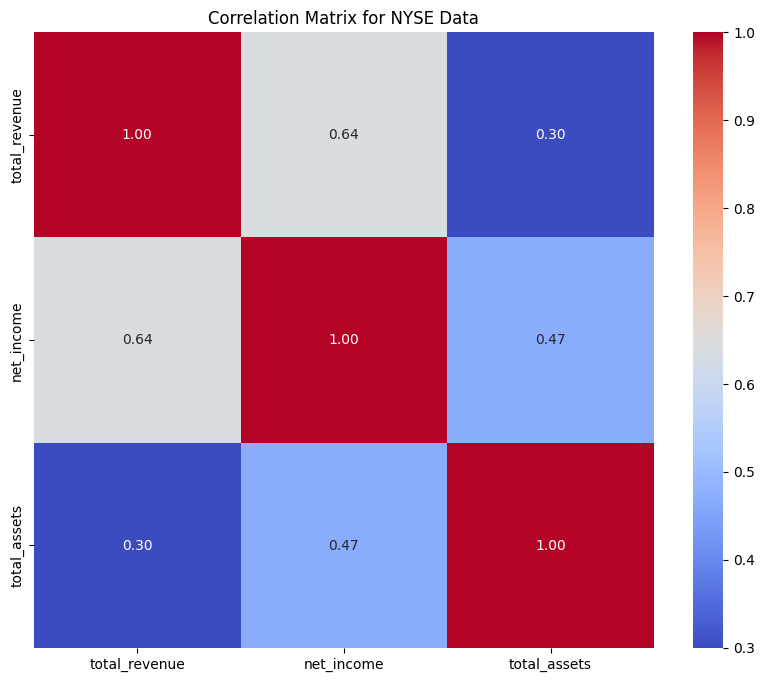

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix for NYSE Data')
plt.show()


The correlation matrix reveals that total revenue and net income are moderately correlated (0.64), indicating that increases in revenue typically lead to rises in income. Total assets show a weaker connection with revenue (0.30) and income (0.47), suggesting asset levels do not directly predict financial performance metrics as strongly.

# 4.2 Trend Analysis

In [22]:
# Check for non-numeric values in the specific columns
for column in ['total_revenue', 'net_income', 'total_assets']:
    non_numeric = df_nyse[df_nyse[column].apply(lambda x: not pd.api.types.is_number(x))]
    print(f"Non-numeric entries in {column}:", non_numeric)


Non-numeric entries in total_revenue: Empty DataFrame
Columns: [symbol, date, total_revenue, net_income, total_assets]
Index: []
Non-numeric entries in net_income: Empty DataFrame
Columns: [symbol, date, total_revenue, net_income, total_assets]
Index: []
Non-numeric entries in total_assets: Empty DataFrame
Columns: [symbol, date, total_revenue, net_income, total_assets]
Index: []


In [23]:
columns_to_convert = ['total_revenue', 'net_income', 'total_assets']
df_nyse[columns_to_convert] = df_nyse[columns_to_convert].apply(pd.to_numeric, errors='coerce')


In [24]:
# Example: Fill NaNs with the mean of the column
for column in columns_to_convert:
    df_nyse[column].fillna(df_nyse[column].mean(), inplace=True)


<ipython-input-24-aa7995057882>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_nyse[column].fillna(df_nyse[column].mean(), inplace=True)


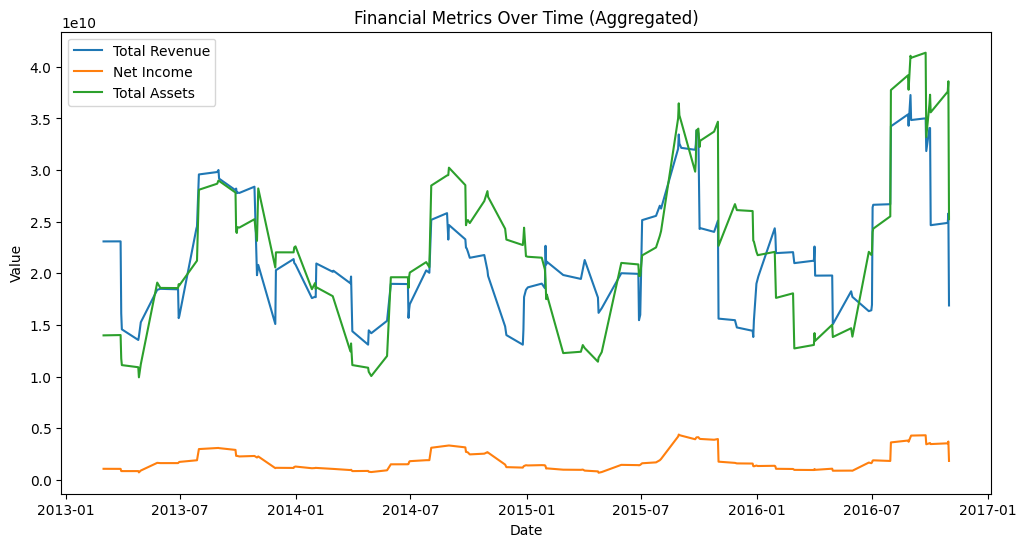

In [28]:
# Exclude the 'symbol' column before calculating the mean
df_grouped = df_nyse.drop(columns=['symbol']).groupby('date').mean()

# Recalculate the rolling mean on the aggregated data
df_grouped['total_revenue'] = df_grouped['total_revenue'].rolling(window=12, center=True).mean()
df_grouped['net_income'] = df_grouped['net_income'].rolling(window=12, center=True).mean()
df_grouped['total_assets'] = df_grouped['total_assets'].rolling(window=12, center=True).mean()

# Plot the smoothed metrics
plt.figure(figsize=(12, 6))
plt.plot(df_grouped.index, df_grouped['total_revenue'], label='Total Revenue')
plt.plot(df_grouped.index, df_grouped['net_income'], label='Net Income')
plt.plot(df_grouped.index, df_grouped['total_assets'], label='Total Assets')
plt.title('Financial Metrics Over Time (Aggregated)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


The trend diagram vividly illustrates the financial dynamics from 2013 to 2017. Total revenue and net income exhibit similar trends, suggesting a correlation between these metrics. The relatively flat line of total assets until a sharp increase in late 2016 indicates a strategic shift or investment, warranting further investigation into the underlying causes.

# 4.3 Seasonal Decomposition Analysis of Total Revenue

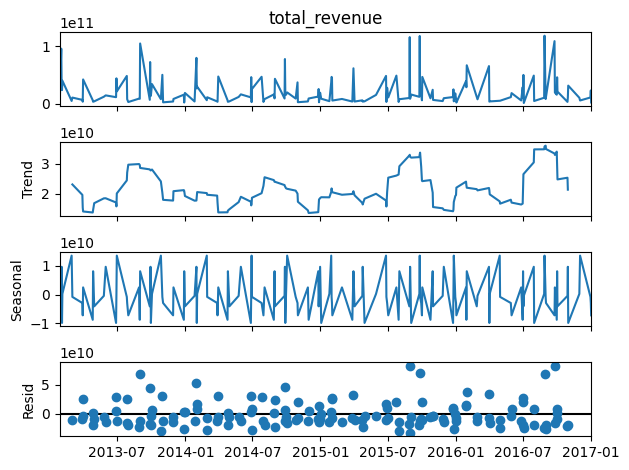

Trend:
 date
2013-01-27   NaN
2013-01-31   NaN
2013-02-01   NaN
2013-02-02   NaN
2013-02-03   NaN
              ..
2016-11-30   NaN
2016-12-02   NaN
2016-12-30   NaN
2016-12-31   NaN
2017-01-01   NaN
Name: trend, Length: 153, dtype: float64
Seasonality:
 date
2013-01-27   -4.084403e+09
2013-01-31   -4.424318e+08
2013-02-01    9.669620e+09
2013-02-02   -9.860264e+09
2013-02-03    2.415427e+08
                  ...     
2016-11-30    2.415427e+08
2016-12-02    1.355324e+10
2016-12-30   -7.989717e+08
2016-12-31   -2.923801e+09
2017-01-01   -7.211860e+09
Name: seasonal, Length: 153, dtype: float64
Residuals:
 date
2013-01-27   NaN
2013-01-31   NaN
2013-02-01   NaN
2013-02-02   NaN
2013-02-03   NaN
              ..
2016-11-30   NaN
2016-12-02   NaN
2016-12-30   NaN
2016-12-31   NaN
2017-01-01   NaN
Name: resid, Length: 153, dtype: float64


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming 'df_nyse' contains your original NYSE data with 'date' and 'total_revenue' columns
# We'll use 'date' as the time component for decomposition

# Group by 'date' and calculate the mean of 'total_revenue'
df_grouped = df_nyse.groupby('date')['total_revenue'].mean().reset_index()

# Set 'date' as the index
df_grouped.set_index('date', inplace=True)

# Select the column to decompose
series = df_grouped['total_revenue']

# Decompose the time series, using the index as the time component
# Adjust the period if your data frequency is different (e.g., 4 for quarterly)
result = seasonal_decompose(series, model='additive', period=12)

# Plot the decomposed components
result.plot()
plt.show()

# Optionally, analyze the results
print("Trend:\n", result.trend)
print("Seasonality:\n", result.seasonal)
print("Residuals:\n", result.resid)

The seasonal decomposition of total revenue for the NYSE data reveals distinct components: a trend indicating overall movement, periodic seasonal fluctuations, and irregular residuals. The trend component shows revenue's long-term movements, while the seasonal pattern highlights systematic fluctuations throughout the period. The residuals depict unexplained variations after accounting for trend and seasonality. This analysis is crucial for understanding underlying patterns and potential cyclical effects within the data.

# Part 5: Data Summarization

# 5.1 Original Data Summarization

In [39]:
print("Summary of Yahoo Finance Data:")
print("Number of records:", df_yahoo.shape[0])
print("Number of columns:", df_yahoo.shape[1])

Summary of Yahoo Finance Data:
Number of records: 1
Number of columns: 5


In [40]:
print("Summary of NYSE Summary Data:")
print("Number of records:", df_nyse_summary.shape[0])
print("Number of columns:", df_nyse_summary.shape[1])

Summary of NYSE Summary Data:
Number of records: 447
Number of columns: 10


# 5.2 Transformed Data Summarization

In [41]:
print("Summary of Merged Data:")
print("Number of records:", df_merged.shape[0])
print("Number of columns:", df_merged.shape[1])

Summary of Merged Data:
Number of records: 1
Number of columns: 14


# Part 6: Error Handling

In [43]:
try:
    # Example operation: Calculate the average market cap from your merged DataFrame
    average_market_cap = df_merged['market_cap'].mean()
    print("Average Market Cap: ", average_market_cap)
except Exception as e:
    # If the operation fails, for example if 'market_cap' column doesn't exist, this will catch the exception
    print(f"Error occurred while calculating market cap: {str(e)}")


Error occurred while calculating market cap: Could not convert string '3591.33B' to numeric


# Part 7: Reflection Report

During this project, one of the main challenges was the merging of financial data from Yahoo Finance and NYSE databases. The complexity arose when aligning these datasets due to differences in data formats and handling non-numeric values, such as market capitalizations listed in formats like '3591.33B', which had to be converted for accurate analysis.

An easier than expected aspect was the utilization of Python's Pandas and Matplotlib libraries. These tools greatly simplified data manipulation and visualization tasks. For example, generating the trend analysis and correlation matrices was straightforward once the data was properly formatted and merged.

However, error handling proved more intricate than anticipated. Developing a robust system to handle exceptions, such as the inability to convert certain string values to numeric types during calculations of average market cap, required meticulous testing and refinement to ensure the ETL process was resilient against data inconsistencies. Additionally, analyzing data in terms of correlation proved difficult, particularly when inconsistencies in data types led to challenges in executing statistical functions correctly.

This utility is a powerful asset for future data projects, especially in financial analysis. By automating the ETL process, it minimizes human error and increases efficiency in data processing. For instance, the ability to quickly and accurately merge and transform data from 'df_yahoo' and 'df_nyse_summary' into 'df_merged' not only streamlines the workflow but also sets the stage for advanced analytical models that can predict market behaviors or identify financial trends from historical data. The lessons learned and the infrastructure built in this project will be invaluable for handling larger datasets or integrating more complex analytics in future projects.